# What is the ideal?
___
### Build a clear and reproducible analysis pipeline

### Send someone your _raw_ data and your analysis scripts/notebook and they can fully reproduce your results. 

### Data -> Preprocessing -> Analysis -> Figure

# Import your packages

In [1]:
import sys

In [2]:
sys.path.append('/Users/chadestep/GitHub/surmeierlab/neurphys/')

In [3]:
# because we made it, and it's awesome
import neurphys as nu

# because we always use them
import os
import itertools
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('estep_style')

# Find the files you want

In [4]:
# Find your raw data
base_direc       = '/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/RAW_DATA/2016/'
sub_direcs       = os.listdir(base_direc)[1:] # stupid .DS_store is listed first...
sub_direc_paths  = ['{0}{1}/'.format(base_direc,sub_direcs[i]) for i,_ in enumerate(sub_direcs)]
all_paths        = [glob('{0}*.abf'.format(sub_direc_paths[i])) for i,_ in enumerate(sub_direc_paths)]

### Currently have
all_paths:  
[&nbsp;[base_direc/sub_direc1/filename1.abf,base_direc/sub_direc1/filename2.abf,...]  
&nbsp;&nbsp;[base_direc/sub_direc2/filename1.abf,base_direc/sub_direc2/filename2.abf,...]&nbsp;]
  
### Want
all_paths:  
[base_direc/sub_direc1/filename1.abf,base_direc/sub_direc1/filename2.abf,... ,base_direc/sub_direc2/filename1.abf,base_direc/sub_direc2/filename2.abf,...]

# Clean up file paths and make useful 

In [5]:
# unnest all_paths list - turn to pandas Series
paths          = pd.Series(list(itertools.chain(*all_paths))) 

# grab all the filenames only since that's what I'm using in my experiment excel file
f              = lambda x: x.split('/')[-1].split('.')[0]
filenames      = paths.apply(f)

# zip the two Series together 
file_path_dict = dict(zip(filenames,paths))

print(file_path_dict.keys())
print('')
print(file_path_dict['2016_04_15_0001'])

dict_keys(['2016_04_13_0007', '2016_04_13_0001', '2016_04_15_0006', '2016_04_13_0006', '2016_04_15_0005', '2016_04_13_0017', '2016_04_13_0011', '2016_04_13_0012', '2016_04_13_0002', '2016_04_15_0001', '2016_04_14_0002', '2016_04_15_0003', '2016_04_13_0010', '2016_04_13_0004', '2016_04_15_0000', '2016_04_13_0003', '2016_04_13_0013', '2016_04_13_0016', '2016_04_13_0000', '2016_04_13_0005', '2016_04_15_0004', '2016_04_13_0008', '2016_04_14_0003', '2016_04_14_0004', '2016_04_13_0014', '2016_04_14_0001', '2016_04_15_0002', '2016_04_14_0000', '2016_04_13_0009', '2016_04_13_0015'])

/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/RAW_DATA/2016/04-14-16 - perf patch rubi-gaba APs/2016_04_15_0001.abf


# Import you excel sheet with relevant experimental data

In [6]:
df_params      = pd.read_excel('/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/Thesis Projects/3 \
- GABA/Data and Figures/GABAB - APs/500ms_uncaging_params.xlsx')
# df_params      = pd.read_excel('/Users/chadestep/Documents/Northwestern/Surmeier/PROJECTS/Thesis Projects/3 \
# - GABA/Data and Figures/GABAB - APs/500ms_uncaging_params2.xlsx')
df_params

,cell,file,fs (Hz),begin (s),duration (s)
0,1,2016_04_13_0006,10000,20.25,0.5
1,2,2016_04_13_0007,10000,20.32,0.5
2,3,2016_04_13_0016,10000,20.67,0.5


# Read in only the files from your excel file

In [7]:
dict_500ms = {}
for file,path in file_path_dict.items():
    if df_params['file'].str.contains(file).any():
        dict_500ms[file] = nu.read_abf(path) 

In [8]:
dict_500ms.keys()

dict_keys(['2016_04_13_0007', '2016_04_13_0006', '2016_04_13_0016'])

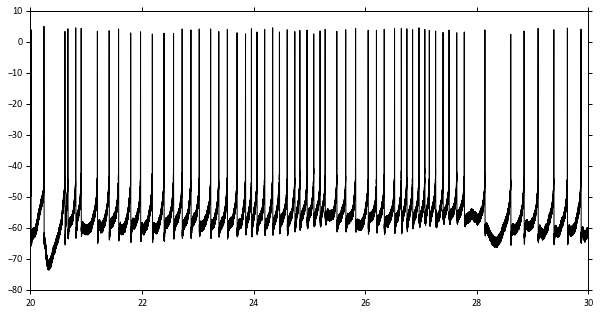

In [9]:
plt.plot(dict_500ms['2016_04_13_0006']['time'],
        dict_500ms['2016_04_13_0006']['primary'])
plt.xlim(20,30)
plt.show()

# Preprocess and give it a look

In [10]:
# nu.pacemaking.detect_peaks?

# Make a new dataframe with spike time data

In [11]:
spike_idx = nu.pacemaking.detect_peaks(dict_500ms['2016_04_13_0006']['primary'],mph=-10)
spike_idx[:5]

array([1159, 3216, 5385, 7375, 9253])

In [12]:
spike_df = dict_500ms['2016_04_13_0006'].iloc[spike_idx]
print(len(spike_df))
spike_df.head()

728


primary    time
sweep                          
sweep001 1159  3.540039  0.1159
         3216  4.455566  0.3216
         5385  3.356933  0.5385
         7375  4.333496  0.7375
         9253  4.028320  0.9253

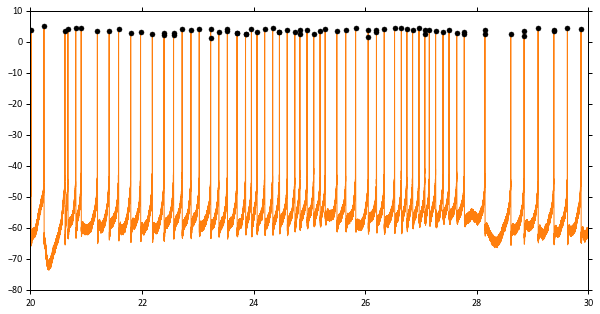

In [13]:
plt.plot(dict_500ms['2016_04_13_0006']['time'],
        dict_500ms['2016_04_13_0006']['primary'],color='#ff7f0e')
plt.plot(spike_df['time'],spike_df['primary'],
         marker='o',markersize=5,color='000000',linestyle='')
plt.xlim(20,30)
plt.show()

### Looks there are a few doubled up. Let's fix that.

638


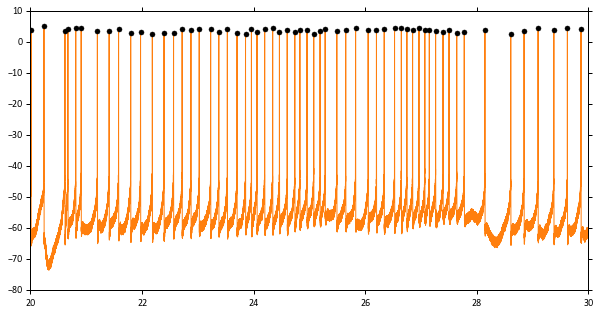

In [14]:
spike_idx = nu.pacemaking.detect_peaks(dict_500ms['2016_04_13_0006']['primary'],mph=-10,mpd=200)
spike_df = dict_500ms['2016_04_13_0006'].iloc[spike_idx]
print(len(spike_df))
plt.plot(dict_500ms['2016_04_13_0006']['time'],
        dict_500ms['2016_04_13_0006']['primary'],color='#ff7f0e')
plt.plot(spike_df['time'],spike_df['primary'],
         marker='o',markersize=5,color='000000',linestyle='')
plt.xlim(20,30)
plt.show()

# Find the firing rates and give it another look

In [15]:
dict_500ms_fr = {}

for key,df in dict_500ms.items():
    spike_idx = nu.pacemaking.detect_peaks(df['primary'],mph=-10,mpd=200)
    spike_df = df.iloc[spike_idx] 
    spike_df['inst freq'] = (spike_df.ix[1:,('time')] - spike_df['time'].shift(1))**-1
    spike_df.dropna(inplace=True)
    spike_df['time'] -= df_params[df_params['file']==key]['begin (s)'].values
    spike_df['normalized fr'] = spike_df['inst freq']/spike_df['inst freq'].mean()
    dict_500ms_fr[key] = spike_df

/Users/chadestep/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chadestep/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chadestep/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/

In [16]:
dict_500ms_fr['2016_04_13_0006'].head()

primary     time  inst freq  normalized fr
sweep                                                      
sweep001 3216   4.455566 -19.9284   4.861449       0.854092
         5385   3.356933 -19.7115   4.610420       0.809990
         7375   4.333496 -19.5125   5.025126       0.882848
         9253   4.028320 -19.3247   5.324814       0.935499
         11045  4.272461 -19.1455   5.580357       0.980395

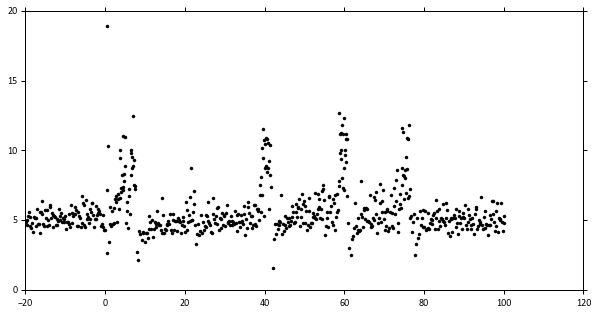

In [17]:
plt.plot(dict_500ms_fr['2016_04_13_0006']['time'],
         dict_500ms_fr['2016_04_13_0006']['inst freq'],
         marker='o',markersize=3,linestyle='')

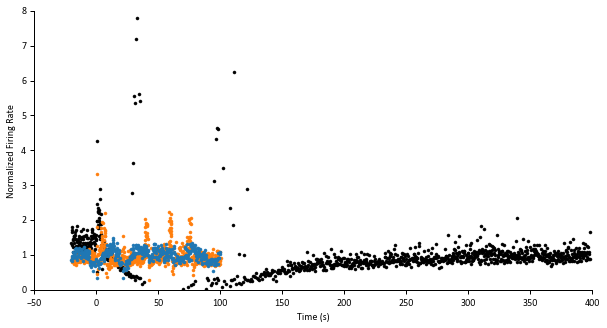

In [18]:
f,ax = plt.subplots()
for key,df in dict_500ms_fr.items():
    ax.plot(df['time'],df['normalized fr'],
            marker='.',linestyle='')
nu.simple_axis(ax)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Firing Rate')
# f.savefig(base_direc+'test.pdf',bbox_inches='tight',pad_inches=0)